# Data analysis of SMI for normal patients

In [113]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

###### Load libraries and directories

In [114]:
from IPython.display import display, HTML

In [115]:
# from IPython import get_ipython
from tqdm.notebook import tqdm
import pickle
import os
import pprint
pp = pprint.PrettyPrinter(indent=1)

import pandas as pd
import numpy as np

import json

# Custom functions
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):        
    with open(filename, 'rb') as input:
        return pickle.load(input)
    

In [116]:
# Install statsmodels if it doesn't exist
def import_or_install(package):
    try:
        return __import__(package)
    except ImportError:
        pip.main(['install', package]) 
        
package = 'statsmodels'

import_or_install(package)

<module 'statsmodels' from '/usr/local/lib/python3.6/dist-packages/statsmodels/__init__.py'>

In [117]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as stats

In [118]:
get_ipython().run_line_magic('tb', '')

NameError: name 'dmatrix' is not defined

In [119]:
cwd = os.getcwd()
print(cwd)
data = '/tf/data'
pickles = '/tf/pickles'
models = '/tf/models'

/tf/smipipeline


In [120]:
# Import modules and config file
configfile = os.path.join(cwd,'config/debug_ES/run_prediction.json')
with open(configfile, "r") as f:
        config = json.load(f)
pp.pprint(config)

{'l3_finder': {'cache_dir': '/tf/_cache/',
               'cache_intermediate_results': True,
               'dicom_dir': '/tf/data',
               'model_path': '/tf/models/l3/child_9_slice_w_transfer_fold_3.h5',
               'new_tim_dicom_dir_structure': True,
               'output_directory': '/tf/output/l3',
               'overwrite': True,
               'save_plots': True,
               'show_plots': False},
 'muscle_segmentor': {'model_path': '/tf/models/muscle/muscle_model_combined_dice_219_fold_1.h5',
                      'output_directory': '/tf/output/ms'}}


## Produce data for analysis using prediction results and preprocessing results

In [121]:
# Load the area csv
sma_csv = os.path.join(config["muscle_segmentor"]["output_directory"],'areas-mm2_by_subject_id.csv')
df_sma = pd.read_csv(sma_csv, index_col=False)
display(df_sma.head(10))

,subject_id,area_mm2,sagittal_series,axial_series
0,Z862651,17094.483348,Z862651-SE-10-Bone_Sagittal_Bone_Bone_3.0,Z862651-SE-5-Std_Axial_Body_Std_5.0
1,Z1452514,10468.547492,Z1452514-SE-9-Bone_Sagittal_Bone_Bone_3.0,Z1452514-SE-4-Std_Axial_Body_Std_5.0
2,Z1244498,4510.328832,Z1244498-SE-7-Bone_Sagittal_3.000,Z1244498-SE-2-Body_5.0
3,Z1196245,5382.606060,Z1196245-SE-5-Sagittal_Body_Sagittal_3.000,Z1196245-SE-2-Axial_Body_5.0
4,Z947752,13457.812500,Z947752-SE-7-Sagittal_Body_Sagittal_3.000,Z947752-SE-4-Axial_Body_5.0
5,Z1174241,9168.764544,Z1174241-SE-12-Body_Std._Axial_AIDR_-_H_Sagitt...,Z1174241-SE-6-Body_Std._Axial_AIDR_-_H_Vol._0.5
6,Z1862275,12393.676800,Z1862275-SE-12-Bone_Pediatric_3.0_CE,Z1862275-SE-7-Std_Pediatric_5.0_CE
7,Z1106026,4754.353968,Z1106026-SE-5-Sagittal_Body,Z1106026-SE-1002-Body_Clarity
8,Z879300,10614.062500,Z879300-SE-10-Bone_Sagittal_Bone_Bone_3.0,Z879300-SE-5-Std_Axial_Body_Std_5.0
9,Z1821697,6882.902208,Z1821697-SE-5-Stnd_Pediatric_3.0_CE,Z1821697-SE-2-Stnd_Pediatric_5.0_CE


In [122]:
# change subject_id to id
df_sma.columns=['ID','area_mm2','sagittals','axials']
display(df_sma.head(2))

,ID,area_mm2,sagittals,axials
0,Z862651,17094.483348,Z862651-SE-10-Bone_Sagittal_Bone_Bone_3.0,Z862651-SE-5-Std_Axial_Body_Std_5.0
1,Z1452514,10468.547492,Z1452514-SE-9-Bone_Sagittal_Bone_Bone_3.0,Z1452514-SE-4-Std_Axial_Body_Std_5.0


In [123]:
# Load the df_final pickle
df_final_d1 = load_object(os.path.join(pickles,'df_final_dump1_processed.pkl'))
print('dump 1 length = ',len(df_final_d1))
df_final_d2 = load_object(os.path.join(pickles,'df_final_dump2_processed.pkl'))
print('dump 2 length = ',len(df_final_d2))

dump 1 length =  1990
dump 2 length =  377


In [124]:
# Merge the  2 dumps
df_final = df_final_d1.append(df_final_d2)
print('df final length = ',len(df_final))

df final length =  2367


In [125]:
# Create the dataframe for analysis by merging df_sma with df_final
# Replace axial and sagittal series in df_final with df_sma that has 
# pointers to reconstructed sagittals, preserve the other fields.
df_final = df_final.drop(columns=['Axial','Sagittal'])
display(df_final.head(10))

,ID,Overlap,MissingScore,PairValidity,AxSlices,SagSlices,AxThick,SagThick,dump,Processed
0,Z1000273,None,1.0,None,78,None,5.0,None,1,1
1,Z1000800,None,1.0,None,124,None,5.0,None,1,1
2,Z1001265,0.998,1.0,1.998,90,99,5.0,3,1,1
3,Z1001413,0.989,1.0,1.989,70,37,5.0,3,1,1
4,Z1001998,0.994,1.0,1.994,68,76,5.0,3,1,1
5,Z1002072,None,1.0,None,66,None,5.0,None,1,1
6,Z1003148,None,1.0,None,92,None,5.0,None,1,1
7,Z1003508,0.994,1.0,1.994,73,86,5.0,3,1,1
8,Z1003895,0.99,1.0,1.99,58,33,5.0,3,1,1
9,Z1004285,0.986,1.0,1.986,70,39,5.0,3,1,1


In [126]:
# Make sure both dfs are equal length
print('Sma len: ', len(df_sma))
print('Final len: ', len(df_final))

Sma len:  2342
Final len:  2367


In [127]:
# 25 cases failed because of L3 level was out of bound, get rid of those for now:
df_final = df_final[df_final['ID'].isin(df_sma['ID'].values)]
print('No of patients processed successfully: ', len(df_final))

No of patients processed successfully:  2342


In [128]:
# Now merge on ID
df_analysis = pd.merge(df_sma,df_final, on="ID")
display(df_analysis.head(10))

,ID,area_mm2,sagittals,axials,Overlap,MissingScore,PairValidity,AxSlices,SagSlices,AxThick,SagThick,dump,Processed
0,Z862651,17094.483348,Z862651-SE-10-Bone_Sagittal_Bone_Bone_3.0,Z862651-SE-5-Std_Axial_Body_Std_5.0,0.996,1.00,1.996,92,51,5.0,3,1,1
1,Z1452514,10468.547492,Z1452514-SE-9-Bone_Sagittal_Bone_Bone_3.0,Z1452514-SE-4-Std_Axial_Body_Std_5.0,0.988,1.00,1.988,86,106,5.0,3,2,1
2,Z1244498,4510.328832,Z1244498-SE-7-Bone_Sagittal_3.000,Z1244498-SE-2-Body_5.0,0.988,1.00,1.988,66,29,5.0,3,1,1
3,Z1196245,5382.606060,Z1196245-SE-5-Sagittal_Body_Sagittal_3.000,Z1196245-SE-2-Axial_Body_5.0,0.988,1.00,1.988,66,74,5.0,3,1,1
4,Z947752,13457.812500,Z947752-SE-7-Sagittal_Body_Sagittal_3.000,Z947752-SE-4-Axial_Body_5.0,1,1.00,2,86,104,5.0,3,1,1
5,Z1174241,9168.764544,Z1174241-SE-12-Body_Std._Axial_AIDR_-_H_Sagitt...,Z1174241-SE-6-Body_Std._Axial_AIDR_-_H_Vol._0.5,0.993,0.96,1.953,1992,87,0.5,3,1,1
6,Z1862275,12393.676800,Z1862275-SE-12-Bone_Pediatric_3.0_CE,Z1862275-SE-7-Std_Pediatric_5.0_CE,0.993,1.00,1.993,89,46,5.0,3,1,1
7,Z1106026,4754.353968,Z1106026-SE-5-Sagittal_Body,Z1106026-SE-1002-Body_Clarity,0.871,1.00,1.871,50,76,5.0,3,1,1
8,Z879300,10614.062500,Z879300-SE-10-Bone_Sagittal_Bone_Bone_3.0,Z879300-SE-5-Std_Axial_Body_Std_5.0,1,1.00,2,89,51,5.0,3,2,1
9,Z1821697,6882.902208,Z1821697-SE-5-Stnd_Pediatric_3.0_CE,Z1821697-SE-2-Stnd_Pediatric_5.0_CE,0.997,1.00,1.997,76,88,5.0,3,1,1


In [129]:
# Load age information from patlist csv
# Load normal patient list
infile  = 'patlist_with_validBMI.csv'
df_P = pd.read_csv(infile, index_col=False)
df_P = df_P.loc[:, ~df_P.columns.str.contains('^Unnamed')]
# Keep only columns needed
df_P = df_P[['PAT_ID','WEIGHT','HEIGHT','BMI_FOR_AGE_PERCENTILE','BMI_CALCULATED','Age',
 'Sex',
 'Race',
 'AgeGroup']]
df_P.columns = ['ID','WEIGHT','HEIGHT','BMI_AGE_P','BMI_CALC','Age','Sex','Race','AgeGroup']
display(df_P.head(10))

,ID,WEIGHT,HEIGHT,BMI_AGE_P,BMI_CALC,Age,Sex,Race,AgeGroup
0,Z704566,23.15,125.00,72.284778,NaN,7.429290,Male,White,7.0
1,Z1931299,10.80,84.00,84.492605,NaN,2.137059,Male,Black or African American,2.0
2,Z664930,23.70,118.00,72.637945,NaN,8.260371,Male,Black or African American,8.0
3,Z1465933,30.80,124.00,87.314049,20.03,9.627373,Female,White,10.0
4,Z1091411,20.75,111.00,84.833169,NaN,5.197492,Male,White,5.0
5,Z585709,43.00,142.00,92.110542,20.23,10.457060,Male,White,10.0
6,Z1161168,80.30,170.18,93.842047,NaN,15.640166,Female,White,16.0
7,Z1137138,32.00,134.62,65.211170,NaN,10.258897,Male,White,10.0
8,Z1329744,8.60,74.00,67.911556,17.71,2.155597,Female,Black or African American,2.0
9,Z1683576,5.90,47.00,7.856420,26.71,0.200078,Female,White,0.0


In [130]:

# Get rid of patients not in df_analysis
print("Total number of normal patients identified", len(df_P))
df_P = df_P[df_P['ID'].isin(df_analysis['ID'].values)]

Total number of normal patients identified 2399


In [131]:
# Merge the patient fields with df_analysis
df_analysis = pd.merge(df_P,df_analysis, on="ID")

# Redefine AgeGroup be flooring instead of rounding.
df_analysis['AgeGroup'] = np.floor(df_analysis['Age'].values)

display(df_analysis.head(10))

,ID,WEIGHT,HEIGHT,BMI_AGE_P,BMI_CALC,Age,Sex,Race,AgeGroup,area_mm2,...,axials,Overlap,MissingScore,PairValidity,AxSlices,SagSlices,AxThick,SagThick,dump,Processed
0,Z704566,23.15,125.00,72.284778,NaN,7.429290,Male,White,7.0,4032.425152,...,Z704566-SE-5-Std_Axial_Body_Std_5.0,0.991,1.0,1.991,66,67,5.0,3,2,1
1,Z1931299,10.80,84.00,84.492605,NaN,2.137059,Male,Black or African American,2.0,2696.428800,...,Z1931299-SE-3-Body_Std._Axial_AIDR_-_H_VOLUME_0.5,1,1.0,2,1024,65,0.5,3,2,1
2,Z664930,23.70,118.00,72.637945,NaN,8.260371,Male,Black or African American,8.0,6505.396092,...,Z664930-SE-4-Std_Axial_Body_Std_5.0,0.988,1.0,1.988,66,74,5.0,3,2,1
3,Z1465933,30.80,124.00,87.314049,20.03,9.627373,Female,White,9.0,6650.133632,...,Z1465933-SE-5-Std_Axial_Body_Std_5.0,0.995,1.0,1.995,76,39,5.0,3,2,1
4,Z1091411,20.75,111.00,84.833169,NaN,5.197492,Male,White,5.0,4931.562636,...,Z1091411-SE-4-Std_Axial_Body_Std_5.0,0.731,1.0,1.731,92,36,5.0,3,2,1
5,Z585709,43.00,142.00,92.110542,20.23,10.457060,Male,White,10.0,7188.172992,...,Z585709-SE-7-Axial_Body__5.0,0.997,1.0,1.997,75,53,5.0,3,2,1
6,Z1161168,80.30,170.18,93.842047,NaN,15.640166,Female,White,15.0,12755.504432,...,Z1161168-SE-4-Stnd_Pediatric_5.0_CE,0.994,1.0,1.994,94,108,5.0,3,2,1
7,Z1137138,32.00,134.62,65.211170,NaN,10.258897,Male,White,10.0,6578.823888,...,Z1137138-SE-2-Stnd_Pediatric_5.0_CE,0.989,1.0,1.989,72,78,5.0,3,2,1
8,Z1329744,8.60,74.00,67.911556,17.71,2.155597,Female,Black or African American,2.0,2534.594400,...,Z1329744-SE-4-Axial_Body_Axial_3.000,None,1.0,None,86,None,3.0,None,2,1
9,Z1683576,5.90,47.00,7.856420,26.71,0.200078,Female,White,0.0,2379.862948,...,Z1683576-SE-3-Axial_Body_VOLUME_0.5,0.953,1.0,1.953,768,59,0.5,1,2,1


In [132]:
# Find missing BMI_CALC
print('Patients missing BMI calculated:' ,len(df_analysis[df_analysis['BMI_CALC'].isnull()]))
print('Patients missing BMI age percentile:' ,len(df_analysis[df_analysis['BMI_AGE_P'].isnull()]))
print('Patients missing Height:' ,len(df_analysis[df_analysis['HEIGHT'].isnull()]))
print('Patients missing Weight' ,len(df_analysis[df_analysis['WEIGHT'].isnull()]))
print('Patients missing Age' ,len(df_analysis[df_analysis['Age'].isnull()]))
print('Patients missing Race' ,len(df_analysis[df_analysis['Race'].isnull()]))
print('Patients missing Sex' ,len(df_analysis[df_analysis['Sex'].isnull()]))

Patients missing BMI calculated: 257
Patients missing BMI age percentile: 0
Patients missing Height: 15
Patients missing Weight 35
Patients missing Age 0
Patients missing Race 0
Patients missing Sex 0


In [133]:
df_analysis = df_analysis.sort_values(by=['AgeGroup'],ascending='False')
#print(df_analysis['AgeGroup'].value_counts().sort_values())

In [134]:
# Patients > 18
print('No of Patients > 18 years' ,len(df_analysis[df_analysis['AgeGroup'] > 18]))
#print('No of Patients < 2.5 yearas' ,len(df_analysis[df_analysis['Age'] < 2.5]))

No of Patients > 18 years 1


In [135]:
print('No of boys' ,len(df_analysis[df_analysis['Sex'] == 'Male']))
print('No of girls' ,len(df_analysis[df_analysis['Sex'] == 'Female']))

No of boys 1139
No of girls 1203


In [136]:
# Create sex stratified and age filtered dfs

df_analysis['area_cm2'] = df_analysis['area_mm2']/100


df_analysis['smi'] = df_analysis['area_cm2']/((df_analysis['HEIGHT']/100)**2)

df_m = df_analysis[(df_analysis['Sex']=='Male') & (df_analysis['AgeGroup'] <= 18)] #& (df_analysis['Age'] > 3)]
print('Length of male df = ',len(df_m))
df_f = df_analysis[(df_analysis['Sex']=='Female') & (df_analysis['AgeGroup'] <= 18)] # & (df_analysis['Age'] > 3)]
print('Length of female df = ',len(df_f))

Length of male df =  1139
Length of female df =  1202


## Population statistics with comparison to growh curves (WHO,CDC)

In [137]:
#Step3: Loop over each unique date in the studies dataframe df_F
def get_agewise_stats(df_in):
    uniqueages = df_in.AgeGroup.unique() 
    column_names = ['AgeGroup','median_area_cm2','median_SMI','samplesize']
    df_C = pd.DataFrame(columns = column_names)
    #display(df_C)
    for age in uniqueages:
        df_l = df_in[df_in['AgeGroup']==age]
        #mean_ar = np.mean(df_l['area_cm2'])
        median_ar = np.median(df_l['area_cm2'])
        median_SMI = np.nanmedian(df_l['smi'])
        samplesize = len(df_l)
        #print([age,mean_ar,median_ar,samplesize])
        df = pd.DataFrame([[age,median_ar,median_SMI,samplesize]],columns=column_names)
        #display(df)
        df_C = pd.concat([df_C,df])
    return df_C

In [138]:
print('Count statistics stratified by gender and age group')
print('(M - Male) (F-Female)')    
df_f_agestats = get_agewise_stats(df_f).add_suffix('_F')
df_m_agestats = get_agewise_stats(df_m).add_suffix('_M')

display(pd.concat([df_f_agestats,df_m_agestats],axis=1))
#df_f_agestats.to_csv(output+'/Female_summary.csv',index=False)

Count statistics stratified by gender and age group
(M - Male) (F-Female)


,AgeGroup_F,median_area_cm2_F,median_SMI_F,samplesize_F,AgeGroup_M,median_area_cm2_M,median_SMI_M,samplesize_M
0,0.0,18.728225,53.509461,6,0.0,19.140264,50.009011,11
0,1.0,28.187172,43.318475,3,1.0,35.348945,47.243737,1
0,2.0,33.176052,38.888135,21,2.0,34.846471,42.148496,38
0,3.0,36.328500,37.202445,23,3.0,38.588332,37.058343,43
0,4.0,39.689819,33.906454,20,4.0,45.575913,37.365109,35
0,5.0,45.799804,35.631040,26,5.0,49.490754,38.643643,50
0,6.0,47.643053,33.250736,44,6.0,51.937982,36.196302,56
0,7.0,52.129974,33.384967,41,7.0,56.784180,36.011985,68
0,8.0,54.926550,32.701449,47,8.0,61.263568,35.151573,51
0,9.0,63.686198,33.720085,58,9.0,69.810243,36.484257,49


### Calculate Z-scores for bmi, height and weight w.r.t to age from WHO/CDC data

In [139]:
#pip install pygrowup
from pygrowup import Calculator
from pygrowup import helpers

calculator = Calculator(include_cdc=True)

def percentile_for_zscore(zscore):
    return stats.norm.cdf(zscore)

def zscore_for_percentile(p):
    return stats.norm.ppf(p)

def add_Z_scores(row):
    try:
        global calculator
        valid_age = row['Age']*12
        valid_gender = helpers.get_good_sex(row['Sex'])
        if (np.isnan(row['HEIGHT'])):
            row['height_age_Zscore'] = row["HEIGHT"]
        else:
            row['height_age_Zscore'] = float(calculator.lhfa(row['HEIGHT'],valid_age,valid_gender))
        
        if (np.isnan(row['WEIGHT'])):
            row['weight_age_Zscore'] = row["WEIGHT"]
        else:
            row['weight_age_Zscore'] = float(calculator.wfa(row['WEIGHT'],valid_age,valid_gender))
            
        if (np.isnan(row['BMI_AGE_P'])):
            row['bmi_age_Zscore'] = row['BMI_AGE_P']
        else:
            row['bmi_age_Zscore'] = zscore_for_percentile(row['BMI_AGE_P']/100)
    except:
        print(row)
        raise
    return row


def add_Zpercentile_scores(row):
    try:
        if (np.isnan(row['weight_age_Zscore'])):
            row['weight_age_Zpercentile'] = row["weight_age_Zscore"]
        else:
            row['weight_age_Zpercentile'] = 100*percentile_for_zscore(row["weight_age_Zscore"])
        
        if (np.isnan(row['height_age_Zscore'])):
            row['height_age_Zpercentile'] = row["height_age_Zscore"]
        else:
            row['height_age_Zpercentile'] = 100*percentile_for_zscore(row["height_age_Zscore"])
    except:
        print(row)
        raise
    return row

In [140]:
df_m = df_m.apply(add_Z_scores,axis=1)
df_m = df_m.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_m = df_m.apply(add_Zpercentile_scores,axis=1)

In [141]:
df_m = df_m.sort_index()
display(df_m[['ID','HEIGHT','WEIGHT','BMI_CALC','height_age_Zscore',
              'height_age_Zpercentile','weight_age_Zscore','weight_age_Zpercentile',
              'bmi_age_Zscore','bmi_age_Zpercentile']].head(50))

,ID,HEIGHT,WEIGHT,BMI_CALC,height_age_Zscore,height_age_Zpercentile,weight_age_Zscore,weight_age_Zpercentile,bmi_age_Zscore,bmi_age_Zpercentile
0,Z704566,125.00,23.15,NaN,0.07,52.790317,-0.31,37.828048,0.591322,72.284778
1,Z1931299,84.00,10.80,NaN,-1.03,15.150500,-1.66,4.845723,1.014912,84.492605
2,Z664930,118.00,23.70,NaN,-2.02,2.169169,-0.75,22.662735,0.601899,72.637945
4,Z1091411,111.00,20.75,NaN,0.16,56.355946,0.69,75.490291,1.029304,84.833169
5,Z585709,142.00,43.00,20.23,0.17,56.749493,1.16,87.697560,1.412546,92.110542
7,Z1137138,134.62,32.00,NaN,-0.82,20.610805,-0.18,42.857628,0.391028,65.211170
10,Z458669,149.86,40.60,NaN,-0.07,47.209683,-0.11,45.620469,0.065240,52.600871
11,Z936182,195.58,71.60,NaN,2.78,99.728206,0.39,65.173173,1.353704,91.208453
13,Z1934105,140.00,42.00,21.43,-2.11,1.742918,-0.46,32.275811,0.935753,82.529984
18,Z1254781,175.26,70.50,NaN,0.41,65.909703,0.95,82.894387,0.829926,79.670978


In [142]:
# Compute descriptive statistics on the dataframe
def calculate_stats(df):
    num_list = ['WEIGHT','HEIGHT','Age','area_cm2','smi','height_age_Zscore','height_age_Zpercentile',
                'weight_age_Zscore','weight_age_Zpercentile','bmi_age_Zscore','bmi_age_Zpercentile']
    df_num = df[num_list]
    df_d = df_num.describe()
    df_whites = df.loc[df['Race']=='White',num_list].describe()
    df_blacks = df.loc[df['Race']=='Black or African American',num_list].describe()
    df_others = df.loc[(df['Race']!='Black or African American') & (df['Race']!='White'),num_list].describe()
    
    df_whites = df_whites.add_suffix('_W')
    df_blacks = df_blacks.add_suffix('_B')
    df_others = df_others.add_suffix('_O')
    return pd.concat([df_d, df_whites,df_blacks,df_others], axis=1)

In [143]:
df_m_stats= calculate_stats(df_m).T.round(decimals=2)
#df_f_stats = calculate_stats(df_f)

In [144]:
display(df_m_stats.head(11))

,count,mean,std,min,25%,50%,75%,max
WEIGHT,1117.0,44.78,20.81,3.80,26.50,43.00,61.90,99.00
HEIGHT,1133.0,147.25,28.10,49.00,127.00,151.00,171.00,205.74
Age,1139.0,11.37,4.56,0.07,7.81,12.07,15.22,18.90
area_cm2,1139.0,91.41,43.42,1.39,56.67,83.42,125.69,217.10
smi,1133.0,39.91,9.05,0.67,34.95,39.69,45.07,73.46
height_age_Zscore,1133.0,0.27,1.19,-5.62,-0.48,0.28,0.99,4.93
height_age_Zpercentile,1133.0,57.09,30.37,0.00,31.56,61.03,83.89,100.00
weight_age_Zscore,1117.0,0.35,0.95,-7.34,-0.24,0.42,1.02,2.85
weight_age_Zpercentile,1117.0,61.22,27.10,0.00,40.52,66.28,84.61,99.78
bmi_age_Zscore,1139.0,0.35,0.81,-1.64,-0.18,0.43,1.01,1.64


### Growth Curve plots

In [145]:
from growth_curves.code.init_processing import aggregate

In [146]:
infile  = '/tf/smipipeline/growth_curves/data/csv/CDC_data.csv'
df_CDC = pd.read_csv(infile, index_col=False)
display(df_CDC.head(10))

#https://www.cdc.gov/growthcharts/percentile_data_files.htm

,gender,age,ht_3,ht_5,ht_10,ht_25,ht_50,ht_75,ht_90,ht_95,...,bmi_3,bmi_5,bmi_10,bmi_25,bmi_50,bmi_75,bmi_85,bmi_90,bmi_95,bmi_97
0,M,0.000000,17.687047,17.940319,18.328461,18.972193,19.680661,20.382386,21.008476,21.380791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M,0.041667,18.889024,19.117358,19.471575,20.070547,20.746449,21.433283,22.060803,22.440583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M,0.125000,20.550626,20.758311,21.084114,21.645315,22.294657,22.972673,23.608819,24.001831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M,0.208333,21.757173,21.958051,22.274693,22.824567,23.468091,24.148772,24.795898,25.199957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M,0.291667,22.728539,22.928126,23.243425,23.793043,24.439764,25.128122,25.786843,26.200350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,M,0.375000,23.553421,23.754516,24.072480,24.627594,25.282228,25.980831,26.651201,27.072984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,M,0.458333,24.277102,24.481343,24.804315,25.368291,26.033587,26.743839,27.425677,27.854835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,M,0.541667,24.926079,25.134512,25.463992,26.038961,26.716606,27.439287,28.132319,28.568138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,M,0.625000,25.517303,25.730646,26.067642,26.655020,27.346094,28.081634,28.785532,29.227429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,M,0.708333,26.062335,26.281094,26.626331,27.227094,27.932299,28.680894,29.395315,29.842811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Correlation metrics

In [147]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 9)
    return pvalues

In [148]:
display(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']].corr().round(3))

,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,1.000,0.933,0.912,0.845,0.892,0.347
HEIGHT,0.933,1.000,0.951,0.665,0.850,0.197
Age,0.912,0.951,1.000,0.689,0.840,0.255
BMI_CALC,0.845,0.665,0.689,1.000,0.751,0.467
area_cm2,0.892,0.850,0.840,0.751,1.000,0.658
smi,0.347,0.197,0.255,0.467,0.658,1.000


In [149]:
display(calculate_pvalues(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']]))

,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0,0,0,0,0,0
HEIGHT,0,0,0,0,0,4e-09
Age,0,0,0,0,0,0
BMI_CALC,0,0,0,0,0,0
area_cm2,0,0,0,0,0,0
smi,0,4e-09,0,0,0,0


## Quantile Regression

In [150]:
# Lets do some quantile regression
mod = smf.quantreg('area_mm2 ~ Age', df_analysis)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:               area_mm2   Pseudo R-squared:               0.4277
Model:                       QuantReg   Bandwidth:                       602.1
Method:                 Least Squares   Sparsity:                        3670.
Date:                Sun, 28 Feb 2021   No. Observations:                 2342
Time:                        18:41:53   Df Residuals:                     2340
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1543.2364    110.229     14.000      0.000    1327.080    1759.393
Age          574.5503      8.511     67.509      0.000     557.861     591.240


In [151]:
def fit_model(q,df,predictor):
    mod = smf.quantreg(predictor+' ~ Age', df)
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['Age']] + \
            res.conf_int().loc['Age'].tolist()

def fit_qreg_ols(df,predictor):
    #quantile reg
    quantiles = np.arange(.25, .76, .25)
    models = [fit_model(x,df,predictor) for x in quantiles]
    models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])
    
    #ols
    ols = smf.ols(predictor+' ~ Age', df).fit()
    ols_ci = ols.conf_int().loc['Age'].tolist()
    ols = dict(a = ols.params['Intercept'],
           b = ols.params['Age'],
           lb = ols_ci[0],
           ub = ols_ci[1])
    return models,ols

def plot_qr(dfs,mlist,olist,sexes=['male','female'],predictor='area_cm2'):
    x = np.arange(0, 19)
    get_y = lambda a, b: a + b * x
    
    plt.figure(figsize = (14,7))
        #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        ols = olist[n]
        ax = plt.subplot(1,2,n+1)
        for i in range(models.shape[0]):
            y = get_y(models.a[i], models.b[i])
            ax.plot(x, y, linestyle='dotted', color='black',label=str(round(models.q[i],2)))

        y = get_y(ols['a'], ols['b'])
        ax.plot(x, y, color='red', label='OLS')
        ax.scatter(df.Age, df[predictor], alpha=.2)
        ax.set_xlim((0, max(df['Age'])))
        ax.set_ylim(min(df[predictor]), max(df[predictor]))
        legend = ax.legend()
        ax.set_xlabel('Age', fontsize=16)
        ax.set_ylabel(predictor, fontsize=16)
        ax.set_title('Quantile regression of '+sexes[n])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


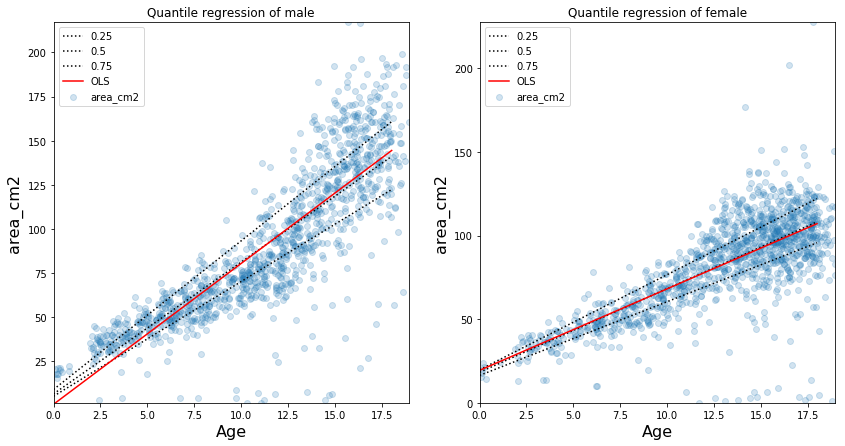

In [152]:
model_m,ols_m = fit_qreg_ols(df_m,'area_cm2')
model_f,ols_f = fit_qreg_ols(df_f,'area_cm2')
plot_qr([df_m,df_f],[model_m,model_f],[ols_m,ols_f],predictor='area_cm2')

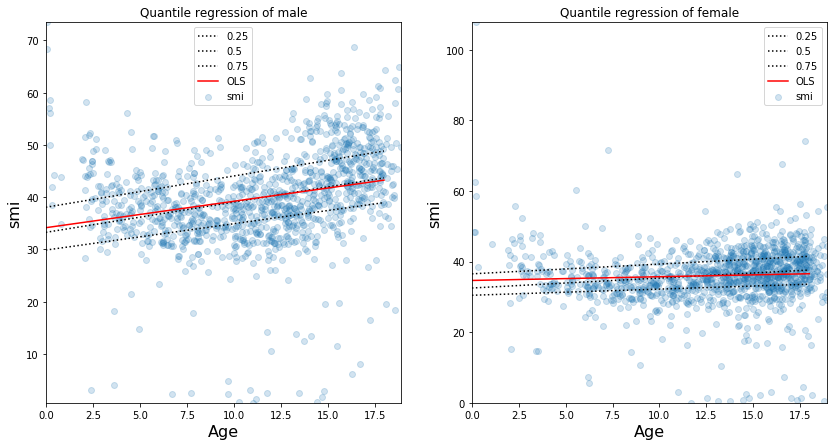

In [153]:
model_m,ols_m = fit_qreg_ols(df_m,'smi')
model_f,ols_f = fit_qreg_ols(df_f,'smi')
plot_qr([df_m,df_f],[model_m,model_f],[ols_m,ols_f],predictor='smi')

In [154]:
def plot_qr_verify(mlist,olist,sexes=['male','female']):
    plt.figure(figsize = (10,5))
    for nn in range(len(mlist)):
        models = mlist[nn]
        ols = olist[nn]
        ax = plt.subplot(1,2,nn+1)
        n = models.shape[0]
        p1 = ax.plot(models.q, models.b, color='black', label='Quantile Reg.')
        p4 = ax.plot(models.q, [ols['b']] * n, color='red', label='OLS')
        p2 = ax.plot(models.q, models.ub, linestyle='dotted', color='black',label=None)
        p3 = ax.plot(models.q, models.lb, linestyle='dotted', color='black',label=None)
        p5 = ax.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
        p6 = ax.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
        #legend = ax.legend()
        ax.set_ylabel(r'$\beta_{age}$', fontsize=12)
        ax.set_xlabel('Quantiles of the SMA distribution', fontsize=12)
        ax.set_title('95% CI for  '+ sexes[nn])
        plt.legend()

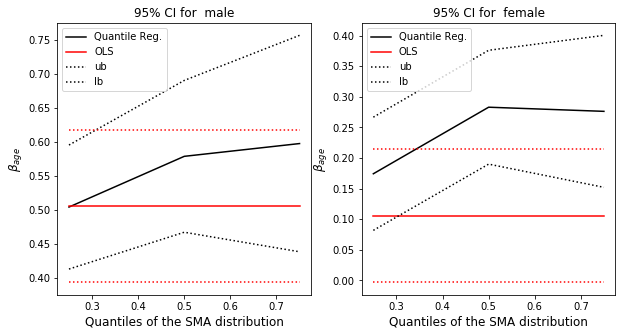

In [155]:
plot_qr_verify([model_m,model_f],[ols_m,ols_f])

## Quantile Regression with Restricted Cubic Splines

In [156]:
from statsmodels.regression.quantile_regression import QuantReg as QR

In [157]:
# Get Restricted Cubic splines by transforming independent variable (age)

# Reference: 
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt


In [158]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_age = dmatrix("bs(train, knots=(3,6,9,12,15), degree=3, include_intercept=False)",
                          {"train": df_m.Age.values},return_type='dataframe')

fit1 = sm.GLM(df_m.area_cm2.values, transformed_age).fit()

pred1 = fit1.predict(dmatrix("bs(valid, knots=(3,6,9,12,15),degree=3, include_intercept=False)",
                             {"valid": df_m.Age.values}, return_type='dataframe'))

rms1 = round(sqrt(mean_squared_error(df_m.area_cm2.values, pred1)),2)
print(rms1)

# Quantile Regression on Cubic b-splines with 5 cuts

knots = '(3,8,12)'
transformed_age = dmatrix("bs(train, knots=" + knots +", degree=2, include_intercept=False)",
                          {"train": df_m.Age.values},return_type='dataframe')

fit1_qr_vlow = QR(df_m.area_cm2.values,transformed_age.values).fit(q=0.10)
fit1_qr_low = QR(df_m.area_cm2.values,transformed_age.values).fit(q=0.25)
fit1_qr_mid = QR(df_m.area_cm2.values,transformed_age.values).fit(q=0.50)
fit1_qr_high = QR(df_m.area_cm2.values,transformed_age.values).fit(q=0.75)
fit1_qr_vhigh = QR(df_m.area_cm2.values,transformed_age.values).fit(q=0.90)

# Prediction on validation set
pred = fit1_qr_mid.predict(transformed_age.values)
# Calculating RMSE value
rms = round(sqrt(mean_squared_error(df_m.area_cm2.values, pred)),2)
print(rms)

qr_inp = dmatrix("bs(xp, knots=" + knots + ", degree=2, include_intercept=False)",
                             {"xp": xp}, return_type='dataframe')
pred3qr_low = fit1_qr_low.predict(qr_inp)
pred3qr_high = fit1_qr_high.predict(qr_inp)
pred3qr_mid = fit1_qr_mid.predict(qr_inp)
pred3qr_vlow = fit1_qr_vlow.predict(qr_inp)
pred3qr_vhigh = fit1_qr_vhigh.predict(qr_inp)


# Plot the splines and error bands
plt.scatter(df_m.Age, df_m.area_cm2, facecolor='None', edgecolor='k', alpha=0.1)
#plt.plot(xp, pred3p, label='Natural spline with 5 knots')
#plt.plot(xp, pred1p, label='Cubic spline with 5 knots')
plt.plot(xp, pred3qr_low, label='0.25 quantile with 5 knots')
plt.plot(xp, pred3qr_mid, label='0.50 quantile with 5 knots')
plt.plot(xp, pred3qr_high, label='0.75 quantile with 5 knots')
plt.plot(xp, pred3qr_vlow, label='0.10 quantile with 5 knots')
plt.plot(xp, pred3qr_vhigh, label='0.90 quantile with 5 knots')
plt.legend()
plt.xlim(0,18)
plt.ylim(0,df_m.area_cm2.values.max())
plt.xlabel('age')
plt.ylabel('muscle area cm^2')
plt.show()


22.04


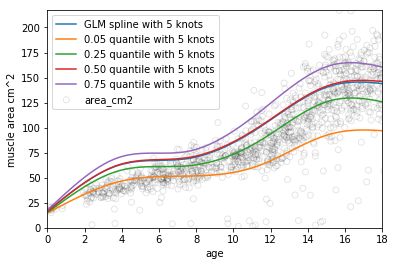

In [161]:
# Natural spline centered

transformed_x3 = dmatrix("cr(train,df = 3) ", {"train": df_m.Age.values}, return_type='dataframe')
fit3 = sm.GLM(df_m.area_cm2.values, transformed_x3).fit()


# Prediction on validation set
pred3 = fit3.predict(transformed_x3)
# Calculating RMSE value
rms = round(sqrt(mean_squared_error(df_m.area_cm2.values, pred3)),2)
print(rms)

df = 5
transformed_x3_cc = dmatrix("cr(train,df = "+ str(df) +",constraints='center')", {"train": df_m.Age.values}, return_type='dataframe')
fit3_cc = sm.GLM(df_m.area_cm2.values, transformed_x3_cc).fit()


model = QR(df_m.area_cm2.values,transformed_x3_cc.values)

fit3_qr_vlow = model.fit(q=0.05)
fit3_qr_low = model.fit(q=0.25)
fit3_qr_mid = model.fit(q=0.50)
fit3_qr_high = model.fit(q=0.75)

# Prediction on validation set
pred3 = fit3_qr_mid.predict(transformed_x3_cc.values)
# Calculating RMSE value
rms = round(sqrt(mean_squared_error(df_m.area_cm2.values, pred3)),2)
print(rms)

# We will plot the graph for 70 observations only
xp = np.linspace(df_m.Age.values.min(),df_m.Age.values.max(),70)

# Make some predictions

#pred1p = fit1.predict(dmatrix("bs(xp, knots=(3,6,9,12,15),degree=3, include_intercept=False)",
#                             {"xp": xp}, return_type='dataframe'))


qr_inp = dmatrix("cr(xp, df="+ str(df)+",constraints='center')", {"xp": xp}, return_type='dataframe').values
pred3p = fit3_cc.predict(qr_inp)

pred3qr_vlow = fit3_qr_vlow.predict(qr_inp)
pred3qr_low = fit3_qr_low.predict(qr_inp)
pred3qr_high = fit3_qr_high.predict(qr_inp)
pred3qr_mid = fit3_qr_mid.predict(qr_inp)

# Plot the splines and error bands
plt.scatter(df_m.Age, df_m.area_cm2, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3p, label='GLM spline with 5 knots')
#plt.plot(xp, pred1p, label='Cubic spline with 5 knots')
plt.plot(xp, pred3qr_vlow, label='0.05 quantile with 5 knots')
plt.plot(xp, pred3qr_low, label='0.25 quantile with 5 knots')
plt.plot(xp, pred3qr_mid, label='0.50 quantile with 5 knots')
plt.plot(xp, pred3qr_high, label='0.75 quantile with 5 knots')
plt.legend()
plt.xlim(0,18)
plt.ylim(0,df_m.area_cm2.values.max())
plt.xlabel('age')
plt.ylabel('muscle area cm^2')
plt.show()